# SDFusion: Text-guided Generation (txt2shape)

### TODO: add sample results or teaser images

In [1]:
!git clone https://github.com/ScheznikL/SDFusion.git
%cd SDFusion
!ls

Cloning into 'SDFusion'...
remote: Enumerating objects: 2021, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 2021 (delta 60), reused 36 (delta 36), pack-reused 1942 (from 2)
Receiving objects: 100% (2021/2021), 36.03 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (844/844), done.
Updating files: 100% (2464/2464), done.
/content/SDFusion
configs		      demo_mm2shape.ipynb	    LICENSE	setup_env.sh
dataset_info_files    demo_txt2shape.ipynb	    models	train.py
datasets	      demo_uncond_shape_comp.ipynb  options	utils
demo_data	      external			    preprocess
demo_img2shape.ipynb  launchers			    README.md


In [ ]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [ ]:
#exit()
#How to run a Python script in a '.py' file from a Google Colab notebook?
from models.base_model import create_model

In [2]:
!pip install h5py joblib trimesh scipy PyMCubes
#pip install --upgrade PyMCubes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.8/336.8 kB 30.1 MB/s eta 0:00:00


In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-t1wrn78q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-t1wrn78q
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60242605 sha256=568909d6c159e2ead5b0cf5b7d3bcf37344c27880e7df9e50534e620fc47d195
  Stored in directory: /tmp/pip-ephem-wheel-cache-m__q2qdi/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=ffc79533490024281623105

In [ ]:
# import libraries
import numpy as np
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

# New section

In [4]:
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=d8984c39e39cf79949e2207f6f535b96af564ec4eaae4b48c629f069dbe9fb04
  Stored in directory: /root/.cache/pip/wheels/1a/97/32/461f837398029ad76911109f07047fde1d7b661a147c7c56d1
Successfully built antlr4-python3-runtime


In [ ]:
# @title Seed 2024
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionText2ShapeOpt

seed = 2024
opt = SDFusionText2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

In [6]:
!mkdir saved_ckpt

In [ ]:
# SDFusion: text-guided shape generation (txt2shape)
!wget https://uofi.box.com/shared/static/vyqs6aex3rwbgxweyl3qh21c8p6vu33f.pth -O saved_ckpt/sdfusion-txt2shape.pth
# VQVAE's checkpoint
!wget https://uofi.box.com/shared/static/zdb9pm9wmxaupzclc7m8gzluj20ja0b6.pth -O saved_ckpt/vqvae-snet-all.pth

In [ ]:
#@title initialize SDFusion model
ckpt_path = 'saved_ckpt/sdfusion-txt2shape.pth'
opt.init_model_args(ckpt_path=ckpt_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

## SDFusion: text-guided generation (txt2shape)

In [ ]:
import os
from datetime import datetime

# txt2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# change the input text here to generate different chairs/tables!
input_txt_old = "A round red color chair with four legs 0.5 meters in length each"
input_txt = "Generate a chair with four legs of 0.53 meters in length, a round seat cushion with a radius of 1/2 of leg length, and a slat back with gaps of 0.11 meters."
book_case_txt = "Generate a bookcase with 4 drawers on top of short bolt legs 0.3 meters each and 3 wide open shelves"
ngen = 1 # number of generated shapes
ddim_steps = 100
ddim_eta = 0.
uc_scale = 3.
# Log start time
start_time = datetime.now()
print(f"{start_time}: Starting txt2shape generation")

sdf_gen = SDFusion.txt2shape(input_txt=book_case_txt, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale)

# Log after sdf_to_mesh generation
end_time = datetime.now()
print(f"{end_time}: Completed sdf_to_mesh")

mesh_gen = sdf_to_mesh(sdf_gen)

'''# Save meshes to .obj and/or .ply
for i, mesh in enumerate(mesh_gen):
    verts, faces = mesh.verts_packed(), mesh.faces_packed()
    # Save to .obj format
    obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}.obj"
    save_obj(obj_path, verts, faces)
    print(f"Saved OBJ to {obj_path}")'''

# vis as gif
#gen_name = f'{out_dir}/txt2shape-{input_txt}.gif'
#save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

#print(f'Input: "{input_txt}"')
#for name in [gen_name]:
#    display(ipy_image(name))

2025-01-29 01:28:25.815905: Starting txt2shape generation
Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


2025-01-29 01:29:07.523167: Completed sdf_to_mesh


'# Save meshes to .obj and/or .ply\nfor i, mesh in enumerate(mesh_gen):\n    verts, faces = mesh.verts_packed(), mesh.faces_packed()\n    # Save to .obj format\n    obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(\' \', \'_\')}.obj"\n    save_obj(obj_path, verts, faces)\n    print(f"Saved OBJ to {obj_path}")'

In [ ]:
#@title save Mesh
#from pytorch3d.io import save_mesh
from pathlib import Path
from pytorch3d.io import IO

out_dir = 'demo_results'

for i, mesh in enumerate(mesh_gen):
  #mesh.textures.faces_verts_textures_packed()

    mesh_path = Path(out_dir) / f"seed2024shape_{i}_{input_txt.split(maxsplit=1)[0]}.ply"
    IO().save_mesh(mesh, mesh_path,include_textures=True) #binary=False, colors_as_uint8=True

# Directory for saving meshes
#out_dir = 'demo_results'
#Path(out_dir).mkdir(parents=True, exist_ok=True)

# Iterate through generated meshes and save each one
'''for i, mesh in enumerate(mesh_gen):
    # Ensure the mesh has only one element
    #mesh = mesh.extend(1)  # Create a single-element Meshes object

    # Define the output path


    # Save the mesh with textures included
    save_mesh(mesh, mesh_path, binary=True, include_textures=True)
    print(f"Saved mesh to {mesh_path}")'''

'for i, mesh in enumerate(mesh_gen):\n    # Ensure the mesh has only one element\n    #mesh = mesh.extend(1)  # Create a single-element Meshes object\n\n    # Define the output path\n\n\n    # Save the mesh with textures included\n    save_mesh(mesh, mesh_path, binary=True, include_textures=True)\n    print(f"Saved mesh to {mesh_path}")'

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
'''
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
'''


'\n# Util function for loading meshes\nfrom pytorch3d.io import load_objs_as_meshes, load_obj\n\n# Data structures and functions for rendering\nfrom pytorch3d.structures import Meshes\nfrom pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene\nfrom pytorch3d.vis.texture_vis import texturesuv_image_matplotlib\nfrom pytorch3d.renderer import (\n    look_at_view_transform,\n    FoVPerspectiveCameras, \n    PointLights, \n    DirectionalLights, \n    Materials, \n    RasterizationSettings, \n    MeshRenderer, \n    MeshRasterizer,  \n    SoftPhongShader,\n    TexturesUV,\n    TexturesVertex\n)\n'

In [ ]:
'''!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid'''

--2025-01-06 00:25:21--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-01-06 00:25:21 (29.3 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [ ]:
'''from pytorch3d.io import save_ply

verts = mesh_gen.verts_packed()
faces = mesh_gen.faces_packed()
verts_rgb = mesh_gen.textures.verts_features_packed()

# Save to PLY
ply_path = Path(out_dir) / "textured_mesh.ply"
save_ply(ply_path, verts, faces)
print(f"Saved PLY with vertex colors to {ply_path}")'''

NameError: name 'Path' is not defined

## display render

TEXTURES ---- <pytorch3d.renderer.mesh.textures.TexturesVertex object at 0x7a033c7674f0>---


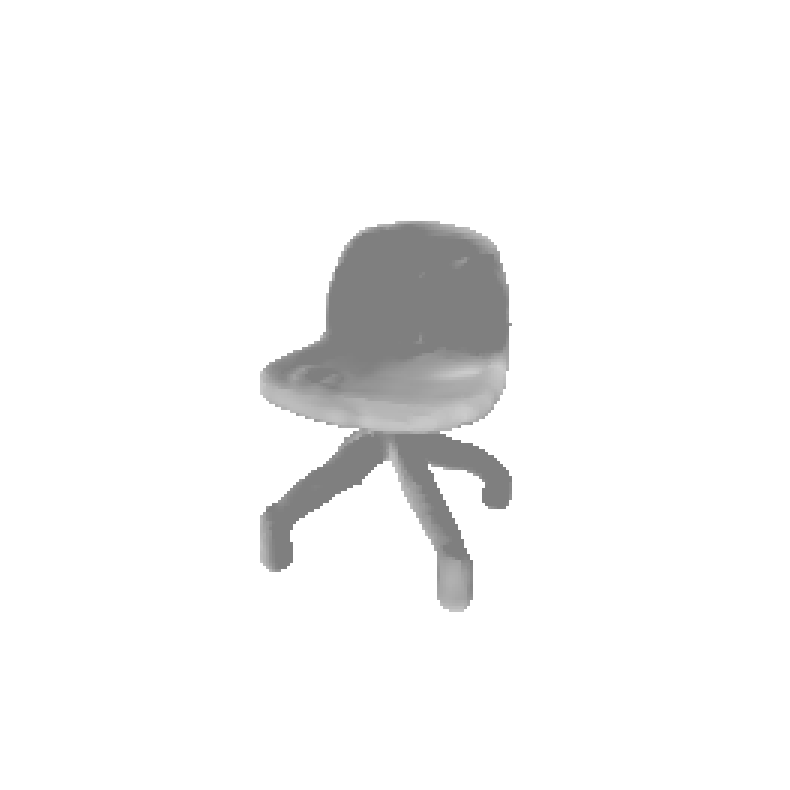

In [ ]:
#images = SDFusion.renderer(mesh)
#mesh.textures.faces_verts_textures_packed()
from pytorch3d.renderer import PointLights

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
lights.location = torch.tensor([0.2, 0.0, 0.0], device=device)[None]

for i, mesh in enumerate(mesh_gen):
    texture_image = mesh.textures.verts_features_padded().squeeze().cpu().numpy()
    img_comb = SDFusion.renderer(mesh, lights=lights)
    print(f"TEXTURES ---- {mesh.textures}---")
    #img_comb = render_mesh(SDFusion.renderer, mesh, norm=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_comb[0, ..., :3].cpu().numpy())
   # plt.imshow(img_comb.cpu().numpy())
    plt.axis("off")

Texture shape: torch.Size([1, 8086, 3])


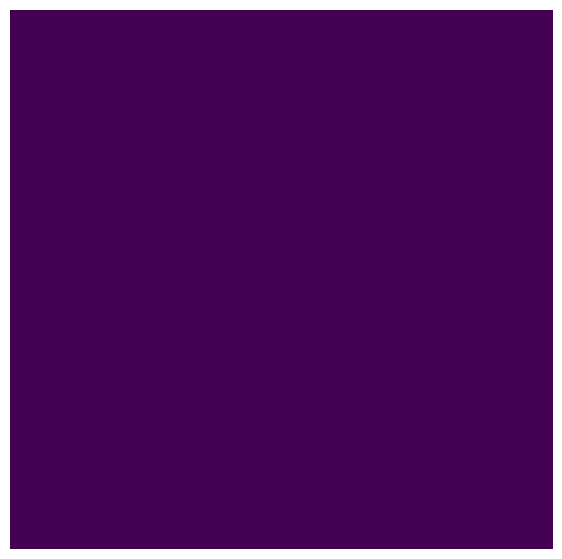

In [ ]:
'''for i, mesh in enumerate(mesh_gen):
  plt.figure(figsize=(7,7))
  texture_image=mesh.textures.verts_features_padded()
  plt.imshow(texture_image.squeeze().cpu().numpy())
  plt.axis("off");'''
for i, mesh in enumerate(mesh_gen):
    plt.figure(figsize=(7, 7))

    # Get vertex features (e.g., RGB values)
    texture_image = mesh.textures.verts_features_padded()  # Shape: (1, N, 3)

    # Check the shape of the texture
    print(f"Texture shape: {texture_image.shape}")

    # Visualize the texture as an array (flattening may be needed)
    texture_image_np = texture_image.squeeze().cpu().numpy()  # Shape: (N, 3)
    plt.imshow(texture_image_np, aspect='auto')  # Display as a continuous line
    plt.axis("off")

In [ ]:
import trimesh
import numpy as np

# Extract vertex positions, faces, and vertex colors
verts = mesh.verts_packed().cpu().numpy()  # (N, 3)
faces = mesh.faces_packed().cpu().numpy()  # (F, 3)
verts_rgb = mesh.textures.verts_features_packed().cpu().numpy()  # (N, 3)

# Create a Trimesh object with vertex colors
trimesh_mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_colors=verts_rgb)#vertex_colors=(verts_rgb * 255).astype(np.uint8)

# Save to .ply
ply_path = Path(out_dir) / f"newshape_{i}_{input_txt.replace(' ', '_')}.ply"
trimesh_mesh.export(ply_path)
print(f"Saved mesh with vertex colors to {ply_path}")


Saved mesh with vertex colors to demo_results/newshape_0_A_round_red_color_chair_with_four_legs_0.5_meters_in_length_each.ply


In [ ]:
from pytorch3d.io import save_obj, save_ply

 # Assuming each mesh has a `textures` attribute with a Textures object
for i, mesh in enumerate(mesh_gen):
    verts, faces = mesh.verts_packed(), mesh.faces_packed()

    # Save geometry and textures to .obj format
    if hasattr(mesh, 'textures') and mesh.textures is not None:
        vertex_colors = mesh.textures.verts_features_packed()  # Extract vertex colors

        # Save to .obj without UVs but with vertex colors
        obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}_textured.obj"
        save_obj(obj_path, verts, faces)  # OBJ doesn't natively support vertex colors
        print(f"Saved OBJ to {obj_path} (vertex colors not directly supported in OBJ)")

        # Save to .ply with vertex colors
        ply_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}_textured.ply"
        save_ply(ply_path, verts, faces, verts_rgb=vertex_colors)
        print(f"Saved PLY to {ply_path} (with vertex colors)")

    else:
        # Save without textures
        obj_path = f"{out_dir}/shape_{i}_{input_txt.replace(' ', '_')}.obj"
        save_obj(obj_path, verts, faces)
        print(f"Saved OBJ (no textures) to {obj_path}")


Saved OBJ to demo_results/shape_0_A_round_red_color_chair_with_four_legs_0.5_meters_in_length_each_textured.obj (vertex colors not directly supported in OBJ)


TypeError: save_ply() got an unexpected keyword argument 'verts_rgb'

# Train

In [5]:
!pip install gdown

In [4]:
#@title test

import gdown

dataset_url = "https://drive.google.com/drive/folders/1xtraL2jb9t3dQCbsJ91exnEJJohGQPIX"
id="1xtraL2jb9t3dQCbsJ91exnEJJohGQPIX"
output = "data"
gdown.download_folder(id=id,output=output)

Retrieving folder contents


Processing file 1IsFlpu0HXJHe7yHwGprLwSkx8gy1qYHl bird.jpg
Processing file 1BPvngBphD8X4_5a4ixGK53Z0YKkCNBZL catstatue.jpg
Processing file 1AAk9Axdfu81qeqGwQU0lv_Wu6-mYnBRr frog_sweater.jpg
Processing file 1ZAcpTT_JlPP4GutcGUDSmQrNI23ybwbO gsorabbit.jpg


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1IsFlpu0HXJHe7yHwGprLwSkx8gy1qYHl
To: /content/data/bird.jpg
100%|██████████| 29.2k/29.2k [00:00<00:00, 45.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BPvngBphD8X4_5a4ixGK53Z0YKkCNBZL
To: /content/data/catstatue.jpg
100%|██████████| 10.8k/10.8k [00:00<00:00, 23.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AAk9Axdfu81qeqGwQU0lv_Wu6-mYnBRr
To: /content/data/frog_sweater.jpg
100%|██████████| 36.3k/36.3k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZAcpTT_JlPP4GutcGUDSmQrNI23ybwbO
To: /content/data/gsorabbit.jpg
100%|██████████| 15.9k/15.9k [00:00<00:00, 31.1MB/s]
Download completed


['data/bird.jpg',
 'data/catstatue.jpg',
 'data/frog_sweater.jpg',
 'data/gsorabbit.jpg']

In [8]:
!mkdir -p data/BuildingNet_dataset_v0_1
#&& cd data/BuildingNet_dataset_v0_1


In [9]:
%cd data
!ls
#'''import os

#os.mkdirs("BuildingNet_dataset_v0_1",exist_ok=True)'''

/content/SDFusion/data
BuildingNet_dataset_v0_1


In [10]:
import gdown

dataset_url = "https://drive.google.com/drive/folders/169v-PBSDj-DIFiWI7HTUAQbna5atUgFW"
id="169v-PBSDj-DIFiWI7HTUAQbna5atUgFW"

output = "BuildingNet_dataset_v0_1"

gdown.download_folder(id=id,output=output)

Retrieving folder contents


Retrieving folder 1JtjkhTq3KNgZtnUh4R11T_kezIDWCSCx 3DWarehouse_IDs
Processing file 1HtRoIpNYhMhkl5K0X4yxb-NWxNfAcwlt 3dwarehouse_ids.csv
Processing file 1ZgZ5bux8edo93bu8vV4Umtb7wDtU8WVB 3dwarehouse_ids.json
Retrieving folder 1AK2jk3WS6az74xlmIdBM-1BatRz0_4bQ model_data
Retrieving folder 1ixOFib3WjHBEKGQXIWHEcodR9qawNHvu GNN
Processing file 1OsW0K3pRaS0RBFt94BdoAXGLb6s4Spv5 adjacency.zip
Processing file 1bPfKEuR9cPsmgAU-rXM_FYspAiFNOQaU containment.zip
Processing file 1CJHkI5VEUvUur1-lDZddqlkbOvEoAlhy label.zip
Processing file 1zyA8PUDZUo5GdAyZNEwnkbEbMRRYSDtH node.zip
Processing file 1gKe6RzE_C9nulSvNZkXraFC2_BEL7gBS pretrained_avgpool_minkownormal_features.zip
Processing file 1_wNGk4cmmoQ8I0Bves0oUGgSZ7OZhmRe similarity.zip
Processing file 1XaLnXXBYdPg54ZcYlNZS_p_anOO80nun support.zip
Processing file 18mh4QXT-AINGwtYiYw6bED461g-w5vrE surfacearea.zip
Processing file 1hbevvRGRc_uKH30iPF8wugxBvsGiHkWy test.txt
Processing file 1P3SwrivpZGDoLmD3iVrv96CkJog89yCF train.txt
Processing file 

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1HtRoIpNYhMhkl5K0X4yxb-NWxNfAcwlt
To: /content/SDFusion/data/BuildingNet_dataset_v0_1/3DWarehouse_IDs/3dwarehouse_ids.csv
100%|██████████| 263k/263k [00:00<00:00, 84.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZgZ5bux8edo93bu8vV4Umtb7wDtU8WVB
To: /content/SDFusion/data/BuildingNet_dataset_v0_1/3DWarehouse_IDs/3dwarehouse_ids.json
100%|██████████| 315k/315k [00:00<00:00, 92.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OsW0K3pRaS0RBFt94BdoAXGLb6s4Spv5
From (redirected): https://drive.google.com/uc?id=1OsW0K3pRaS0RBFt94BdoAXGLb6s4Spv5&confirm=t&uuid=fc866e7f-4680-428c-84a3-3badb9ceb3fe
To: /content/SDFusion/data/BuildingNet_dataset_v0_1/model_data/GNN/adjacency.zip
100%|██████████| 62.9M/62.9M [00:00<00:00, 100MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1bPfKEuR9cPsmgA

['BuildingNet_dataset_v0_1/3DWarehouse_IDs/3dwarehouse_ids.csv',
 'BuildingNet_dataset_v0_1/3DWarehouse_IDs/3dwarehouse_ids.json',
 'BuildingNet_dataset_v0_1/model_data/GNN/adjacency.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/containment.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/label.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/node.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/pretrained_avgpool_minkownormal_features.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/similarity.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/support.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/surfacearea.zip',
 'BuildingNet_dataset_v0_1/model_data/GNN/test.txt',
 'BuildingNet_dataset_v0_1/model_data/GNN/train.txt',
 'BuildingNet_dataset_v0_1/model_data/GNN/val.txt',
 'BuildingNet_dataset_v0_1/model_data/obj/component_labels.zip',
 'BuildingNet_dataset_v0_1/model_data/obj/face_labels.zip',
 'BuildingNet_dataset_v0_1/model_data/obj/faceindex_componentID.zip',
 'BuildingNet_dataset_v0_1

In [14]:
!ls
%cd data
!ls

configs		    demo_img2shape.ipynb	  launchers   README.md
data		    demo_mm2shape.ipynb		  LICENSE     saved_ckpt
dataset_info_files  demo_txt2shape.ipynb	  models      setup_env.sh
datasets	    demo_uncond_shape_comp.ipynb  options     train.py
demo_data	    external			  preprocess  utils
/content/SDFusion/data
BuildingNet_dataset_v0_1


In [16]:
#@title unzip the dataset
# Replace this with the actual URL you get after filling the form

#dataset_filename = "BuildingNet_dataset_v0_1.zip"
folder_target_1="BuildingNet_dataset_v0_1/OBJ_MODELS.zip"
folder_target_2="BuildingNet_dataset_v0_1/POINT_CLOUDS.zip"
# Unzip to ./data/
!unzip -q {folder_target_1} -d 'BuildingNet_dataset_v0_1'
!unzip -q {folder_target_2} -d "BuildingNet_dataset_v0_1"


Streaming output truncated to the last 5000 lines.
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh1969.obj  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh1981.mtl  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh1981.obj  
   creating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/Brick_Pavers_Modular.jpg  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/Brick_Pavers_Modular_1.jpg  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/Groundcover_RiverRock_4inch.jpg  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/Tile_Hexagon_White.jpg  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/Tile_Hexagon_White_0.jpg  
  inflating: BuildingNet_dataset_v0_1/OBJ_MODELS/RESIDENTIALvilla_mesh2039/Tile_Limestone_Multi.jpg  
  inflating

In [20]:
%cd ..


/content/SDFusion/preprocess


In [21]:
!ls

create_buildingnet_split.py  create_snet_text_split.py	launchers
create_sdf.py		     isosurface			process_one_mesh.py


create_buildingnet_split.py  create_snet_text_split.py	launchers
create_sdf.py		     isosurface			process_one_mesh.py
sh: 1: source: not found
Traceback (most recent call last):
  File "/content/SDFusion/preprocess/create_sdf.py", line 914, in <module>
    create_sdf_building(sdf_cmd, mcube_cmd, "source %s" % lib_cmd,
  File "/content/SDFusion/preprocess/create_sdf.py", line 643, in create_sdf_building
    list_obj = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if '.obj' in f]
                                                    ^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '../data/ShapeNet/ShapeNetCore.v1/OBJ_MODELS'
/content/SDFusion
configs		    demo_img2shape.ipynb	  launchers   README.md
data		    demo_mm2shape.ipynb		  LICENSE     saved_ckpt
dataset_info_files  demo_txt2shape.ipynb	  models      setup_env.sh
datasets	    demo_uncond_shape_comp.ipynb  options     train.py
demo_data	    external			  preprocess  utils


In [ ]:
%cd preprocess
# Delete a specific Python file
!rm -f create_sdf.py

### create_sdf.py

In [ ]:
%%writefile create_sdf.py

# modify from https://github.com/Xharlie/DISN/blob/master/preprocessing/create_point_sdf_grid.py

from random import choices
import h5py
import os
import argparse
import numpy as np
import glob

from joblib import Parallel, delayed
import trimesh
from scipy.interpolate import RegularGridInterpolator
import time
import json

CUR_PATH = os.path.dirname(os.path.realpath(__file__))

parser = argparse.ArgumentParser()
parser.add_argument('--dset', type=str, choices=['shapenet', 'abc', 'pix3d', 'building'], default='shapenet', help='which dataset to extract sdf')
parser.add_argument('--thread_num', type=int, default='9', help='how many objs are creating at the same time')
parser.add_argument('--reduce', type=int, default=4, help='define resolution. res=256//reduce')
parser.add_argument('--category', type=str, default="all", help='Which single class to generate on [default: all, can '
                                                                'be chair or plane, etc.]')
FLAGS = parser.parse_args()

def get_sdf_value(sdf_pt, sdf_params_ph, sdf_ph, sdf_res):
    num_point = sdf_pt.shape[0]
    # x = np.linspace(sdf_params_ph[0], sdf_params_ph[3], num=sdf_res+1)
    # y = np.linspace(sdf_params_ph[1], sdf_params_ph[4], num=sdf_res+1)
    # z = np.linspace(sdf_params_ph[2], sdf_params_ph[5], num=sdf_res+1)
    x = np.linspace(sdf_params_ph[0], sdf_params_ph[3], num=sdf_res)
    y = np.linspace(sdf_params_ph[1], sdf_params_ph[4], num=sdf_res)
    z = np.linspace(sdf_params_ph[2], sdf_params_ph[5], num=sdf_res)
    my_interpolating_function = RegularGridInterpolator((z, y, x), sdf_ph)
    sdf_value = my_interpolating_function(sdf_pt)
    print("sdf_value:", sdf_value.shape)
    return np.expand_dims(sdf_value, axis=1)

def get_sdf(sdf_file, sdf_res):
    intsize = 4
    floatsize = 8
    sdf = {
        "param": [],
        "value": []
    }
    with open(sdf_file, "rb") as f:
        try:
            bytes = f.read()
            ress = np.fromstring(bytes[:intsize * 3], dtype=np.int32)
            if -1 * ress[0] != sdf_res or ress[1] != sdf_res or ress[2] != sdf_res:
                raise Exception(sdf_file, "res not consistent with ", str(sdf_res))
            positions = np.fromstring(bytes[intsize * 3:intsize * 3 + floatsize * 6], dtype=np.float64)
            # bottom left corner, x,y,z and top right corner, x, y, z
            sdf["param"] = [positions[0], positions[1], positions[2],
                            positions[3], positions[4], positions[5]]
            sdf["param"] = np.float32(sdf["param"])
            sdf["value"] = np.fromstring(bytes[intsize * 3 + floatsize * 6:], dtype=np.float32)
            sdf["value"] = np.reshape(sdf["value"], (sdf_res + 1, sdf_res + 1, sdf_res + 1)) # somehow the cube is sdf_res+1 rather than sdf_res... need to investigate why
        finally:
            f.close()
    return sdf

def get_offset_ball(num, bandwidth):
    u = np.random.normal(0, 1, size=(num,1))
    v = np.random.normal(0, 1, size=(num,1))
    w = np.random.normal(0, 1, size=(num,1))
    r = np.random.uniform(0, 1, size=(num,1)) ** (1. / 3) * bandwidth
    norm = np.linalg.norm(np.concatenate([u, v, w], axis=1),axis=1, keepdims=1)
    # print("u.shape",u.shape)
    # print("norm.shape",norm.shape)
    # print("r.shape",r.shape)
    (x, y, z) = r * (u, v, w) / norm
    return np.concatenate([x,y,z],axis=1)

def get_offset_cube(num, bandwidth):
    u = np.random.normal(0, 1, size=(num,1))
    v = np.random.normal(0, 1, size=(num,1))
    w = np.random.normal(0, 1, size=(num,1))
    r = np.random.uniform(0, 1, size=(num,1)) ** (1. / 3) * bandwidth
    norm = np.linalg.norm(np.concatenate([u, v, w], axis=1),axis=1, keepdims=1)
    # print("u.shape",u.shape)
    # print("norm.shape",norm.shape)
    # print("r.shape",r.shape)
    (x, y, z) = r * (u, v, w) / norm
    return np.concatenate([x,y,z],axis=1)

def sample_sdf(num_sample, bandwidth, iso_val, sdf_dict, sdf_res, reduce):
    start = time.time()
    params = sdf_dict["param"]
    sdf_values = sdf_dict["value"].flatten()
    # print("np.min(sdf_values), np.mean(sdf_values), np.max(sdf_values)",
    #       np.min(sdf_values), np.mean(sdf_values), np.max(sdf_values))

    # n_sample = sdf_res // reduce + 1
    n_sample = sdf_res // reduce # want 64 * 64 * 64

    x = np.linspace(params[0], params[3], num=n_sample).astype(np.float32)
    y = np.linspace(params[1], params[4], num=n_sample).astype(np.float32)
    z = np.linspace(params[2], params[5], num=n_sample).astype(np.float32)
    z_vals, y_vals, x_vals = np.meshgrid(z, y, x, indexing='ij')
    print("x_vals", x_vals[0, 0, sdf_res // reduce - 1])
    # x_original = np.linspace(params[0], params[3], num=sdf_res + 1).astype(np.float32)
    # y_original = np.linspace(params[1], params[4], num=sdf_res + 1).astype(np.float32)
    # z_original = np.linspace(params[2], params[5], num=sdf_res + 1).astype(np.float32)
    x_original = np.linspace(params[0], params[3], num=sdf_res+1).astype(np.float32)
    y_original = np.linspace(params[1], params[4], num=sdf_res+1).astype(np.float32)
    z_original = np.linspace(params[2], params[5], num=sdf_res+1).astype(np.float32)
    x_ind = np.arange(n_sample).astype(np.int32)
    y_ind = np.arange(n_sample).astype(np.int32)
    z_ind = np.arange(n_sample).astype(np.int32)
    zv, yv, xv = np.meshgrid(z_ind, y_ind, x_ind, indexing='ij')
    choosen_ind = xv * reduce + yv * (sdf_res+1) * reduce + zv * (sdf_res+1)**2 * reduce
    choosen_ind = np.asarray(choosen_ind, dtype=np.int32).reshape(-1)
    vals = sdf_values[choosen_ind]
    x_vals = x[xv.reshape(-1)]
    y_vals = y[yv.reshape(-1)]
    z_vals = z[zv.reshape(-1)]

    # pdb.set_trace()
    # sdf_pt_val = np.stack((x_vals, y_vals, z_vals, vals), axis = -1)
    sdf_pt_val = np.expand_dims(vals, axis= -1 )
    # print("np.min(vals), np.mean(vals), np.max(vals)", np.min(vals), np.mean(vals), np.max(vals))
    print("sdf_pt_val.shape", sdf_pt_val.shape)
    print("sample_sdf: {} s".format(time.time()-start))
    return sdf_pt_val, check_insideout(sdf_values, sdf_res, x_original,y_original,z_original)

def check_insideout(sdf_val, sdf_res, x, y, z):
    # "chair": "03001627",
    # "bench": "02828884",
    # "cabinet": "02933112",
    # "car": "02958343",
    # "airplane": "02691156",
    # "display": "03211117",
    # "lamp": "03636649",
    # "speaker": "03691459",
    # "rifle": "04090263",
    # "sofa": "04256520",
    # "table": "04379243",
    # "phone": "04401088",
    # "watercraft": "04530566"

    # if cat_id in ["02958343", "02691156", "04530566"]:
    x_ind = np.argmin(np.absolute(x))
    y_ind = np.argmin(np.absolute(y))
    z_ind = np.argmin(np.absolute(z))
    all_val = sdf_val.flatten()
    # num_val = all_val[x_ind+y_ind*(sdf_res+1)+z_ind*(sdf_res+1)**2]
    num_val = all_val[x_ind+y_ind*(sdf_res)+z_ind*(sdf_res)**2]
    return num_val > 0.0
    # else:
        # return False

def create_h5_sdf_pt(h5_file, sdf_file, flag_file, norm_obj_file,
         centroid, m, sdf_res, num_sample, bandwidth, iso_val, max_verts, normalize, reduce=8):
    sdf_dict = get_sdf(sdf_file, sdf_res)
    ori_verts = np.asarray([0.0,0.0,0.0], dtype=np.float32).reshape((1,3))
    # Nx3(x,y,z)
    print("ori_verts", ori_verts.shape)
    samplesdf, is_insideout = sample_sdf(num_sample, bandwidth, iso_val, sdf_dict, sdf_res, reduce)  # (N*8)x4 (x,y,z)
    if is_insideout:
        with open(flag_file, "w") as f:
            f.write("mid point sdf val > 0")
        print("insideout !!:", sdf_file)
    else:
        os.remove(flag_file) if os.path.exists(flag_file) else None
    print("samplesdf", samplesdf.shape)
    print("start to write",h5_file)
    norm_params = np.concatenate((centroid, np.asarray([m]).astype(np.float32)))
    f1 = h5py.File(h5_file, 'w')
    f1.create_dataset('pc_sdf_original', data=ori_verts.astype(np.float32), compression='gzip', compression_opts=4)
    f1.create_dataset('pc_sdf_sample', data=samplesdf.astype(np.float32), compression='gzip', compression_opts=4)
    f1.create_dataset('norm_params', data=norm_params, compression='gzip', compression_opts=4)
    f1.create_dataset('sdf_params', data=sdf_dict["param"], compression='gzip', compression_opts=4)
    f1.close()
    print("end writing",h5_file)
    command_str = "rm -rf " + norm_obj_file
    print("command:", command_str)
    os.system(command_str)
    command_str = "rm -rf " + sdf_file
    print("command:", command_str)
    os.system(command_str)

def get_param_from_h5(sdf_h5_file, cat_id, obj):
    h5_f = h5py.File(sdf_h5_file, 'r')
    try:
        if 'norm_params' in h5_f.keys():
            norm_params = h5_f['norm_params'][:]
        else:
            raise Exception(cat_id, obj, "no sdf and sample")
    finally:
        h5_f.close()
    return norm_params[:3], norm_params[3]


def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(scene_or_mesh, trimesh.Trimesh))
        mesh = trimesh.Trimesh(vertices=scene_or_mesh.vertices, faces=scene_or_mesh.faces)
    return mesh


# def get_normalize_mesh(model_file, norm_sdf_file, cat_id, obj, sdf_sub_dir):

#     print("load mesh from ", model_file)
#     mesh_list = trimesh.load_mesh(model_file, process=False)
#     #if not isinstance(mesh_list, list):
#     #    mesh_list = [mesh_list]
#     #largest_ind = 0
#     #largest_sur = 0
#     #for idx, mesh in enumerate(mesh_list):
#     #    area = np.sum(mesh.area_faces)
#     #    if largest_sur < area:
#     #        largest_ind = idx
#     #        largest_sur = area
#     #mesh = mesh_list[largest_ind]
#     mesh = as_mesh(mesh_list)
#     centroid, m = get_param_from_h5(norm_sdf_file, cat_id, obj)
#     mesh.vertices = (mesh.vertices - centroid) / float(m)
#     obj_file = os.path.join(sdf_sub_dir,"pc_norm.obj")
#     print("exporting", obj_file)
#     trimesh.exchange.export.export_mesh(mesh, obj_file, file_type="obj")
#     print("export_mesh", obj_file)
#     return obj_file, centroid, m

# from DISN create_point_sdf_grid
def get_normalize_mesh(model_file, norm_mesh_sub_dir):
    total = 16384
    print("trimesh_load:", model_file)
    mesh_list = trimesh.load_mesh(model_file, process=False)
    print("[*] done!", model_file)

    # NOTE: used to load with pymesh!
    #       change to trimesh
    # pymesh.load_mesh(model_file)

    mesh = as_mesh(mesh_list) # from s2s
    if not isinstance(mesh, list):
        mesh_list = [mesh]

    area_sum = 0
    area_lst = []
    for idx, mesh in enumerate(mesh_list):
        area = np.sum(mesh.area_faces)
        area_lst.append(area)
        area_sum+=area
    area_lst = np.asarray(area_lst)
    amount_lst = (area_lst * total / area_sum).astype(np.int32)
    points_all=np.zeros((0,3), dtype=np.float32)
    for i in range(amount_lst.shape[0]):
        mesh = mesh_list[i]
        print("start sample surface of ", mesh.faces.shape[0])
        points, index = trimesh.sample.sample_surface(mesh, amount_lst[i])
        print("end sample surface")
        points_all = np.concatenate([points_all,points], axis=0)
    centroid = np.mean(points_all, axis=0)
    points_all = points_all - centroid
    m = np.max(np.sqrt(np.sum(points_all ** 2, axis=1)))
    if '/pix3d/' in model_file:
        model_basename = os.path.basename(model_file)
        pc_norm_name = model_basename.replace('model', 'pc_norm')
        obj_file = os.path.join(norm_mesh_sub_dir, pc_norm_name)
    else:
        obj_file = os.path.join(norm_mesh_sub_dir, "pc_norm.obj")

    # NOTE: used to load with pymesh!
    #       change to trimesh
    # ori_mesh = pymesh.load_mesh(model_file)
    # print("centroid, m", centroid, m)
    # try:
        # pymesh.save_mesh_raw(obj_file, (ori_mesh.vertices - centroid) / float(m), ori_mesh.faces)
    # except:
        # import pdb; pdb.set_trace()

    ori_mesh_list = trimesh.load_mesh(model_file, process=False)
    ori_mesh = as_mesh(ori_mesh_list)
    ori_mesh.vertices = (ori_mesh.vertices - centroid) / float(m)
    ori_mesh.export(obj_file)

    # print("export_mesh", obj_file)
    # print('EXIST?????', os.path.exists(obj_file), obj_file)
    return obj_file, centroid, m


def create_one_sdf(sdfcommand, res, expand_rate, sdf_file, obj_file, indx, g=0.0):

    command_str = sdfcommand + " " + obj_file + " " + str(res) + " " + str(res) + \
       " " + str(res) + " -s " + " -e " + str(expand_rate) + " -o " + str(indx) + ".dist -m 1"
    command_str += ' -c'
    if g > 0.0:
        command_str += " -g " + str(g)
    print("command:", command_str)
    os.system(command_str)
    command_str2 = "mv " + str(indx)+".dist " + sdf_file
    print("command:", command_str2)
    os.system(command_str2)


# s2s
# def create_sdf_obj(sdfcommand, marching_cube_command, cat_mesh_dir, cat_norm_mesh_dir, cat_norm_sdf_dir, cat_sdf_dir, obj,
#        res, iso_val, expand_rate, indx, ish5, normalize, num_sample, bandwidth, max_verts, cat_id, g, reduce):

def create_sdf_obj(sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj,
       res, iso_val, expand_rate, indx, ish5, normalize, num_sample, bandwidth, max_verts, g, reduce):
    # obj = obj.rstrip('\r\n')
    # model_file = obj

    # norm_mesh_sub_dir = os.path.join(norm_mesh_dir, os.path.basename(obj).replace('.obj', ''))
    # sdf_sub_dir = os.path.join(sdf_dir, os.path.basename(obj).replace('.obj', ''))

    if FLAGS.dset == 'abc':
        model_id = os.path.basename(obj).replace('.obj', '')
    elif FLAGS.dset == 'pix3d':
        model_id = obj.split('/')[-2]
    elif FLAGS.dset == 'building':
        model_id = os.path.basename(obj).replace('.obj', '')
    elif FLAGS.dset == 'shapenet':
        model_id = obj.split('/')[-2]
    norm_mesh_sub_dir = os.path.join(norm_mesh_dir, model_id)
    sdf_sub_dir = os.path.join(sdf_dir, model_id)

    if not os.path.exists(norm_mesh_sub_dir): os.makedirs(norm_mesh_sub_dir)
    if not os.path.exists(sdf_sub_dir): os.makedirs(sdf_sub_dir)

    if FLAGS.dset == 'pix3d':
        obj_basename = os.path.basename(obj).replace('.obj', '')
        sdf_name = obj_basename.replace('model', 'isosurf')
        flag_name = obj_basename.replace('model', 'isinsideout')
        h5_name = obj_basename.replace('model', 'ori_sample_grid')

        sdf_file = os.path.join(sdf_sub_dir, f"{sdf_name}.sdf")
        flag_file = os.path.join(sdf_sub_dir, f"{flag_name}.txt")
        h5_file = os.path.join(sdf_sub_dir, f"{h5_name}.h5")
    else:
        sdf_file = os.path.join(sdf_sub_dir, "isosurf.sdf")
        flag_file = os.path.join(sdf_sub_dir, "isinsideout.txt")
        h5_file = os.path.join(sdf_sub_dir, "ori_sample_grid.h5")

    if ish5 and os.path.exists(h5_file) and not os.path.exists(flag_file):
        print("skip existed: ", h5_file)
    elif not ish5 and os.path.exists(sdf_file):
        print("skip existed: ", sdf_file)
    else:
        # model_file = os.path.join(cat_mesh_dir, obj, "models", "model_normalized.obj")
        # model_file = os.path.join(cat_mesh_dir, obj, "model.obj")
        model_file = os.path.join(obj)
        print("creating", sdf_file)
        if normalize:
            norm_obj_file, centroid, m = get_normalize_mesh(model_file, norm_mesh_sub_dir)

        create_one_sdf(sdfcommand, res, expand_rate, sdf_file, norm_obj_file, indx, g=g)
        # create_one_cube_obj(marching_cube_command, iso_val, sdf_file, cube_obj_file)
        # change to h5
        if ish5:
            create_h5_sdf_pt(h5_file, sdf_file, flag_file, norm_obj_file,
                 centroid, m, res, num_sample, bandwidth, iso_val, max_verts, normalize, reduce=reduce)
        # except:
        #     print("%%%%%%%%%%%%%%%%%%%%%%%% fail to process ", model_file)

def create_one_cube_obj(marching_cube_command, i, sdf_file, cube_obj_file):
    command_str = marching_cube_command + " " + sdf_file + " " + cube_obj_file + " -i " + str(i)
    print("command:", command_str)
    os.system(command_str)
    return cube_obj_file

def create_sdf_abc(sdfcommand, marching_cube_command, LIB_command,
               num_sample, bandwidth, res, expand_rate, raw_dirs, iso_val,
               max_verts, ish5=True, normalize=True, g=0.00, reduce=4):
    '''
    Usage: SDFGen <filename> <dx> <padding>
    Where:
        res is number of grids on xyz dimension
        w is narrowband width
        expand_rate is sdf range of max x,y,z
    '''
    #cats_init = cats
    #cats = cats_init
    #cats['airplane'] = cats_init['airplane']
    #print("command:", LIB_command)
    os.system(LIB_command)
    start=0
    for split in ['train', 'test']:

        model_dir = os.path.join(raw_dirs['mesh_dir'], split, '2048')
        norm_mesh_dir = os.path.join(raw_dirs["norm_mesh_dir"], split)
        sdf_dir = os.path.join(raw_dirs["sdf_dir"], split)

        if not os.path.exists(sdf_dir): os.makedirs(sdf_dir)
        if not os.path.exists(norm_mesh_dir): os.makedirs(norm_mesh_dir)

        # list_obj = os.listdir(model_dir)
        list_obj = [os.path.join(model_dir, f) for f in os.listdir(model_dir)]
        repeat = len(list_obj)
        sdfcommand_lst=[sdfcommand for i in range(repeat)]
        marching_cube_command_lst=[marching_cube_command for i in range(repeat)]
        norm_mesh_dir_lst=[norm_mesh_dir for i in range(repeat)] # by yc
        sdf_dir_lst=[sdf_dir for i in range(repeat)]
        res_lst=[res for i in range(repeat)]
        iso_val_lst=[iso_val for i in range(repeat)]
        expand_rate_lst=[expand_rate for i in range(repeat)]
        indx_lst = [i for i in range(start, start+repeat)]
        ish5_lst=[ish5 for i in range(repeat)]
        normalize_lst=[normalize for i in range(repeat)]
        num_sample_lst=[num_sample for i in range(repeat)]
        bandwidth_lst=[bandwidth for i in range(repeat)]
        max_verts_lst=[max_verts for i in range(repeat)]
        g_lst=[g for i in range(repeat)]
        reduce_lst=[reduce for i in range(repeat)]

        with Parallel(n_jobs=5) as parallel:
            parallel(delayed(create_sdf_obj)
            (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)
            for sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
                expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce
                in zip(sdfcommand_lst,
                       marching_cube_command_lst,
                       norm_mesh_dir_lst,
                       sdf_dir_lst,
                       list_obj,
                       res_lst,
                       iso_val_lst,
                       expand_rate_lst,
                       indx_lst, ish5_lst, normalize_lst, num_sample_lst,
                       bandwidth_lst, max_verts_lst, g_lst, reduce_lst))

        # debug
        # for (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
        #     expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce) in \
        #     zip(sdfcommand_lst, marching_cube_command_lst, norm_mesh_dir_lst, sdf_dir_lst, list_obj,
        #         res_lst, iso_val_lst, expand_rate_lst, indx_lst, ish5_lst, normalize_lst, num_sample_lst,
        #         bandwidth_lst, max_verts_lst, g_lst, reduce_lst):
        #         create_sdf_obj(
        #             sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res,
        #             iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)
        start+=repeat
    print("finish all")


def create_sdf_pix3d(sdfcommand, marching_cube_command, LIB_command,
               num_sample, bandwidth, res, expand_rate,
               lst_dir, all_cats, raw_dirs, iso_val,
               max_verts, ish5=True, normalize=True, g=0.00, reduce=4):
    '''
    Usage: SDFGen <filename> <dx> <padding>
    Where:
        res is number of grids on xyz dimension
        w is narrowband width
        expand_rate is sdf range of max x,y,z
    '''
    #cats_init = cats
    #cats = cats_init
    #cats['airplane'] = cats_init['airplane']
    #print("command:", LIB_command)
    os.system(LIB_command)
    start=0

    """ load input text. this is for chair. """
    # input_txt = '../../data/pix3d/input.txt'
    # with open(input_txt, 'r') as f:
    #     lines = [l.strip('\n')[3:] for l in f.readlines()] # no ../

    # gt_txt = input_txt.replace('input', 'gt')
    # with open(gt_txt, 'r') as f:
    #     gt_lines = [l.strip('\n')[3:] for l in f.readlines()] # no ../

    lst_dir
    dataroot = lst_dir.split('/pix3d/filelists')[0]
    with open(f'{dataroot}/pix3d/pix3d.json', 'r') as f:
        pix3d_info = json.load(f)
    pix3d_root = f'{dataroot}/pix3d'

    # map_input_to_info = {}
    # for d in pix3d_info:
    #     img_name = d['img']
    #     img_name = os.path.splitext(img_name)[0]
    #     map_input_to_info[img_name] = d


    for cat in all_cats:

        # if cat != 'chair':
            # continue

        model_dir = os.path.join(raw_dirs['mesh_dir'], cat)
        norm_mesh_dir = os.path.join(raw_dirs["norm_mesh_dir"], cat)
        sdf_dir = os.path.join(raw_dirs["sdf_dir"], cat)

        if not os.path.exists(norm_mesh_dir): os.makedirs(norm_mesh_dir)
        if not os.path.exists(sdf_dir): os.makedirs(sdf_dir)

        # list_obj = os.listdir(model_dir)
        list_model_id = []
        train_lst = f'{lst_dir}/{cat}_train.lst'
        test_lst = f'{lst_dir}/{cat}_test.lst'
        with open(train_lst, 'r') as f:
            list_model_id = f.readlines()
        with open(test_lst, 'r') as f:
            list_model_id += f.readlines()

        # get all obj file
        list_obj = []
        for model_id in list_model_id:

            # again, different case for chair
            if cat == 'chair':

                # here basically just copy from 'pix3d_align_shapenet'
                p = model_id
                p = p.rstrip('\n')
                model_id = p.split('/')[-2]

                # # find gt voxel file.
                # img_name = os.path.basename(p)
                # img_name = os.path.splitext(img_name)[0]
                # key = f'img/{cat}/{img_name}'
                # pix3d_img_name = map_input_to_info[key]['img']

                # # test file
                # if pix3d_img_name in lines:
                #     ix = lines.index(pix3d_img_name)
                #     gt_voxel_name = gt_lines[ix]
                #     gt_voxel_bn = os.path.basename(gt_voxel_name)
                #     obj_bn = gt_voxel_bn.replace('voxel', 'model')
                #     obj_bn = obj_bn.replace('.mat', '.obj')

                #     obj_f = f'{pix3d_root}/model_align/{cat}/{model_id}/{obj_bn}'

                #     if 'IKEA_JULES_1' in obj_f:
                #         kkk = obj_f
                #         import pdb; pdb.set_trace()

                # # train file.
                # else:
                #     # train file.
                #     # take the first one. for some model, there are multiple obj files
                #     obj_f = glob.glob(f'{pix3d_root}/model_align/{cat}/{model_id}/*.obj')[0]

                obj_files = glob.glob(f'{model_dir}/{model_id}/*.obj')#[0]

                # list_obj += obj_files
                # if obj_f not in list_obj:
                #     list_obj.append(obj_f)
            else:
                model_id = model_id.rstrip('\n')
                obj_files = glob.glob(f'{model_dir}/{model_id}/*.obj')#[0]
                # list_obj.append(obj_f)

            for obj_f in obj_files:
                if obj_f not in list_obj:
                    list_obj.append(obj_f)

        # list_obj = [kkk]
        # import pdb; pdb.set_trace()

        repeat = len(list_obj)
        sdfcommand_lst=[sdfcommand for i in range(repeat)]
        marching_cube_command_lst=[marching_cube_command for i in range(repeat)]
        norm_mesh_dir_lst=[norm_mesh_dir for i in range(repeat)] # by yc
        sdf_dir_lst=[sdf_dir for i in range(repeat)]
        res_lst=[res for i in range(repeat)]
        iso_val_lst=[iso_val for i in range(repeat)]
        expand_rate_lst=[expand_rate for i in range(repeat)]
        indx_lst = [i for i in range(start, start+repeat)]
        ish5_lst=[ish5 for i in range(repeat)]
        normalize_lst=[normalize for i in range(repeat)]
        num_sample_lst=[num_sample for i in range(repeat)]
        bandwidth_lst=[bandwidth for i in range(repeat)]
        max_verts_lst=[max_verts for i in range(repeat)]
        g_lst=[g for i in range(repeat)]
        reduce_lst=[reduce for i in range(repeat)]

        # not sure why, n_jobs=2 fails...
        with Parallel(n_jobs=5) as parallel:
            parallel(delayed(create_sdf_obj)
            (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)
            for sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
                expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce
                in zip(sdfcommand_lst,
                       marching_cube_command_lst,
                       norm_mesh_dir_lst,
                       sdf_dir_lst,
                       list_obj,
                       res_lst,
                       iso_val_lst,
                       expand_rate_lst,
                       indx_lst, ish5_lst, normalize_lst, num_sample_lst,
                       bandwidth_lst, max_verts_lst, g_lst, reduce_lst))

        # debug
        # for (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
        #     expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce) in \
        #     zip(sdfcommand_lst, marching_cube_command_lst, norm_mesh_dir_lst, sdf_dir_lst, list_obj,
        #         res_lst, iso_val_lst, expand_rate_lst, indx_lst, ish5_lst, normalize_lst, num_sample_lst,
        #         bandwidth_lst, max_verts_lst, g_lst, reduce_lst):
        #         create_sdf_obj(
        #             sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res,
        #             iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)

        start+=repeat
    print("finish all")



def create_sdf_building(sdfcommand, marching_cube_command, LIB_command,
               num_sample, bandwidth, res, expand_rate, raw_dirs, iso_val,
               max_verts, ish5=True, normalize=True, g=0.00, reduce=4):
    '''
    Usage: SDFGen <filename> <dx> <padding>
    Where:
        res is number of grids on xyz dimension
        w is narrowband width
        expand_rate is sdf range of max x,y,z
    '''
    #cats_init = cats
    #cats = cats_init
    #cats['airplane'] = cats_init['airplane']
    #print("command:", LIB_command)
    os.system(LIB_command)
    start=0

    resolution = int(res // reduce)

    model_dir = os.path.join(raw_dirs['mesh_dir'], 'OBJ_MODELS')
    norm_mesh_dir = os.path.join(raw_dirs["norm_mesh_dir"])
    sdf_dir = os.path.join(raw_dirs["sdf_dir"], f'resolution_{resolution}')

    if not os.path.exists(sdf_dir): os.makedirs(sdf_dir)
    if not os.path.exists(norm_mesh_dir): os.makedirs(norm_mesh_dir)

    # list_obj = os.listdir(model_dir)
    list_obj = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if '.obj' in f]

    repeat = len(list_obj)
    sdfcommand_lst=[sdfcommand for i in range(repeat)]
    marching_cube_command_lst=[marching_cube_command for i in range(repeat)]
    norm_mesh_dir_lst=[norm_mesh_dir for i in range(repeat)] # by yc
    sdf_dir_lst=[sdf_dir for i in range(repeat)]
    res_lst=[res for i in range(repeat)]
    iso_val_lst=[iso_val for i in range(repeat)]
    expand_rate_lst=[expand_rate for i in range(repeat)]
    indx_lst = [i for i in range(start, start+repeat)]
    ish5_lst=[ish5 for i in range(repeat)]
    normalize_lst=[normalize for i in range(repeat)]
    num_sample_lst=[num_sample for i in range(repeat)]
    bandwidth_lst=[bandwidth for i in range(repeat)]
    max_verts_lst=[max_verts for i in range(repeat)]
    g_lst=[g for i in range(repeat)]
    reduce_lst=[reduce for i in range(repeat)]

    with Parallel(n_jobs=5) as parallel:
        parallel(delayed(create_sdf_obj)
        (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)
        for sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
            expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce
            in zip(sdfcommand_lst,
                    marching_cube_command_lst,
                    norm_mesh_dir_lst,
                    sdf_dir_lst,
                    list_obj,
                    res_lst,
                    iso_val_lst,
                    expand_rate_lst,
                    indx_lst, ish5_lst, normalize_lst, num_sample_lst,
                    bandwidth_lst, max_verts_lst, g_lst, reduce_lst))

    # debug
    # for (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
    #     expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce) in \
    #     zip(sdfcommand_lst, marching_cube_command_lst, norm_mesh_dir_lst, sdf_dir_lst, list_obj,
    #         res_lst, iso_val_lst, expand_rate_lst, indx_lst, ish5_lst, normalize_lst, num_sample_lst,
    #         bandwidth_lst, max_verts_lst, g_lst, reduce_lst):
    #         create_sdf_obj(
    #             sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res,
    #             iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)
    #         import pdb; pdb.set_trace()
    start+=repeat
    print("finish all")



def create_sdf_shapenet(sdfcommand, marching_cube_command, LIB_command,
               num_sample, bandwidth, res, expand_rate,
               lst_dir, all_cats, raw_dirs, iso_val,
               max_verts, ish5=True, normalize=True, g=0.00, reduce=4):
    '''
    Usage: SDFGen <filename> <dx> <padding>
    Where:
        res is number of grids on xyz dimension
        w is narrowband width
        expand_rate is sdf range of max x,y,z
    '''
    os.system(LIB_command)
    start=0

    """ load input text. this is for chair. """

    print("command:", LIB_command)
    # import subprocess
    # subprocess.run(LIB_command)
    os.system(LIB_command)
    # import pdb; pdb.set_trace()

    resolution = int(res // reduce)
    sdf_root = raw_dirs["sdf_dir"]
    sdf_dir = os.path.join(sdf_root, f'resolution_{resolution}') # .../ShapeNet/SDF_v1
    if not os.path.exists(sdf_dir): os.makedirs(sdf_dir)

    # map_input_to_info = {}
    # for d in pix3d_info:
    #     img_name = d['img']
    #     img_name = os.path.splitext(img_name)[0]
    #     map_input_to_info[img_name] = d

    # sanity check: all files exists
    for catnm in all_cats:

        print(f'[*] checking obj files in {catnm} ({cats[catnm]})')

        cat_id = cats[catnm]
        cat_mesh_dir = os.path.join(raw_dirs["mesh_dir"], cat_id)
        with open(lst_dir+"/"+str(cat_id)+"_test.lst", "r") as f:
            list_obj = f.readlines()

        with open(lst_dir+"/"+str(cat_id)+"_train.lst", "r") as f:
            list_obj += f.readlines()

        list_obj = [f.rstrip() for f in list_obj]
        list_obj = [f'{cat_mesh_dir}/{f}/model.obj' for f in list_obj]

        for f in list_obj:
            if not os.path.exists(f):
                print(f)
                import pdb; pdb.set_trace()
            assert os.path.exists(f)

        print(f'[*] all files exist for {catnm} ({cats[catnm]})!')


    for catnm in all_cats:

        cat_id = cats[catnm]
        cat_sdf_dir = os.path.join(sdf_dir, cat_id)
        if not os.path.exists(cat_sdf_dir): os.makedirs(cat_sdf_dir)
        cat_mesh_dir = os.path.join(raw_dirs["mesh_dir"], cat_id)
        cat_norm_mesh_dir = os.path.join(raw_dirs["norm_mesh_dir"], cat_id)

        with open(lst_dir+"/"+str(cat_id)+"_test.lst", "r") as f:
            list_obj = f.readlines()
        with open(lst_dir+"/"+str(cat_id)+"_train.lst", "r") as f:
            list_obj += f.readlines()

        list_obj = [f.rstrip() for f in list_obj]
        list_obj = [f'{cat_mesh_dir}/{f}/model.obj' for f in list_obj]

        # model_dir = os.path.join(raw_dirs['mesh_dir'], cat)
        # norm_mesh_dir = os.path.join(raw_dirs["norm_mesh_dir"], cat)
        # cat_sdf_dir = os.path.join(raw_dirs["sdf_dir"], cat)
        # if not os.path.exists(norm_mesh_dir): os.makedirs(norm_mesh_dir)
        # if not os.path.exists(cat_sdf_dir): os.makedirs(cat_sdf_dir)

        repeat = len(list_obj)
        sdfcommand_lst=[sdfcommand for i in range(repeat)]
        marching_cube_command_lst=[marching_cube_command for i in range(repeat)]
        # norm_mesh_dir_lst=[norm_mesh_dir for i in range(repeat)] # by yc
        # sdf_dir_lst=[sdf_dir for i in range(repeat)]
        norm_mesh_dir_lst=[cat_norm_mesh_dir for i in range(repeat)] # by yc
        sdf_dir_lst=[cat_sdf_dir for i in range(repeat)] # by yc
        res_lst=[res for i in range(repeat)]
        iso_val_lst=[iso_val for i in range(repeat)]
        expand_rate_lst=[expand_rate for i in range(repeat)]
        indx_lst = [i for i in range(start, start+repeat)]
        ish5_lst=[ish5 for i in range(repeat)]
        normalize_lst=[normalize for i in range(repeat)]
        num_sample_lst=[num_sample for i in range(repeat)]
        bandwidth_lst=[bandwidth for i in range(repeat)]
        max_verts_lst=[max_verts for i in range(repeat)]
        g_lst=[g for i in range(repeat)]
        reduce_lst=[reduce for i in range(repeat)]

        # not sure why, n_jobs=2 fails...
        with Parallel(n_jobs=5) as parallel:
            parallel(delayed(create_sdf_obj)
            (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)
            for sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
                expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce
                in zip(sdfcommand_lst,
                       marching_cube_command_lst,
                       norm_mesh_dir_lst,
                       sdf_dir_lst,
                       list_obj,
                       res_lst,
                       iso_val_lst,
                       expand_rate_lst,
                       indx_lst, ish5_lst, normalize_lst, num_sample_lst,
                       bandwidth_lst, max_verts_lst, g_lst, reduce_lst))

        # debug
        # for (sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res, iso_val,
        #     expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce) in \
        #     zip(sdfcommand_lst, marching_cube_command_lst, norm_mesh_dir_lst, sdf_dir_lst, list_obj,
        #         res_lst, iso_val_lst, expand_rate_lst, indx_lst, ish5_lst, normalize_lst, num_sample_lst,
        #         bandwidth_lst, max_verts_lst, g_lst, reduce_lst):
        #         create_sdf_obj(
        #             sdfcommand, marching_cube_command, norm_mesh_dir, sdf_dir, obj, res,
        #             iso_val, expand_rate, indx, ish5, norm, num_sample, bandwidth, max_verts, g, reduce)

        start+=repeat
    print("finish all")


# def test_sdf(sdf_h5_file):
#     h5_f = h5py.File(sdf_h5_file, 'r')
#     red = np.asarray([255.0, 0, 0]).astype(np.float32)
#     blue = np.asarray([0, 0, 255.0]).astype(np.float32)
#     try:
#         if ('pc_sdf_original' in h5_f.keys() and 'pc_sdf_sample' in h5_f.keys()):
#             ori_sdf = h5_f['pc_sdf_original'][:]
#             sample_sdf = np.reshape(h5_f['pc_sdf_sample'][:], (-1, 4))
#             ori_pt, ori_sdf_val = ori_sdf[:, :3], ori_sdf[:, 3]
#             sample_pt, sample_sdf_val = sample_sdf[:, :3], sample_sdf[:, 3]
#             minval, maxval = np.min(ori_sdf_val), np.max(ori_sdf_val)
#             sdf_pt_color = np.zeros([ori_pt.shape[0], 6], dtype=np.float32)
#             sdf_pt_color[:, :3] = ori_pt
#             for i in range(sdf_pt_color.shape[0]):
#                 sdf_pt_color[i, 3:] = red + (blue - red) * (
#                             float(ori_sdf_val[i] - minval) / float(maxval - minval))
#             np.savetxt("./ori.txt", sdf_pt_color)
#
#             sample_pt_color = np.zeros([sample_pt.shape[0], 6], dtype=np.float32)
#             sample_pt_color[:, :3] = sample_pt
#             minval, maxval = np.min(sample_sdf_val), np.max(sample_sdf_val)
#             for i in range(sample_pt_color.shape[0]):
#                 sample_pt_color[i, 3:] = red + (blue - red) * (
#                         float(sample_sdf_val[i] - minval) / float(maxval - minval))
#             np.savetxt("./sample.txt", sample_pt_color)
#     finally:
#         h5_f.close()



if __name__ == "__main__":

    # nohup python -u create_point_sdf_fullgrid.py &> createfull.log &
    # lst_dir, cats, all_cats, raw_dirs = create_file_lst_abc.get_all_info()

    dset = FLAGS.dset
    cat = FLAGS.category

    # lst_dir, cats, all_cats, raw_dirs = get_sdf_file_lst.get_all_info(dset)

    #info_file = '../dataset_info_files/info-shapenet.json'
    info_file = '../dataset_info_files/info-building.json'
    with open(info_file) as json_file:
        info_data = json.load(json_file)
        lst_dir, cats, all_cats, raw_dirs = info_data["lst_dir"], info_data['cats'], info_data['all_cats'], info_data['raw_dirs_v1']

    if dset == 'shapenet':
        if cat != 'all':
            cats = {cat: cats[cat]}
    elif dset != 'abc':
        if cat == 'all':
            FLAGS.cats = all_cats
        else:
            FLAGS.cats = [cat]

    isosurface_dir = './isosurface'
    sdf_cmd = f'{isosurface_dir}/computeDistanceField'
    mcube_cmd = f'{isosurface_dir}/computeMarchingCubes'
    lib_cmd = f'{isosurface_dir}/LIB_PATH'

    # set env variable
    os.environ['LD_LIBRARY_PATH'] = f'$LD_LIBRARY_PATH:{isosurface_dir}:./isosurface/tbb/tbb2018_20180822oss/lib/intel64/gcc4.7/'

    num_sample = 65 ** 3
    bandwidth = 0.1
    res = 256
    reduce = FLAGS.reduce
    expand_rate = 1.3
    iso_val = 0.003
    max_verts = 16384

    #  full set
    # create_sdf(sdfcommand,
    #            mcube_cmd,
    #            "source %s" % lib_cmd, 274625, 0.1,
    #            256, 1.3, all_cats, cats, raw_dirs,
    #            lst_dir, 0.003, 16384, ish5=True, normalize=True, g=0.00, reduce=4)
    # create_sdf_obj(sdfcommand,
    #            mcube_cmd,
    #            "source %s" % lib_cmd, num_sample, bandwidth,
    #            res, expand_rate, raw_dirs, iso_val, max_verts, ish5=True, normalize=True, g=0.00, reduce=4)

    if dset == 'abc':
        create_sdf_abc(sdf_cmd, mcube_cmd, "source %s" % lib_cmd,
                   num_sample, bandwidth, res, expand_rate, raw_dirs, iso_val,
                   max_verts, ish5=True, normalize=True, g=0.00, reduce=reduce)
    elif dset == 'pix3d':
        create_sdf_pix3d(sdf_cmd, mcube_cmd, "source %s" % lib_cmd,
                   num_sample, bandwidth, res, expand_rate,
                   lst_dir, FLAGS.cats, raw_dirs,
                   iso_val, max_verts, ish5=True, normalize=True, g=0.00, reduce=reduce)
    elif dset == 'building':
        create_sdf_building(sdf_cmd, mcube_cmd, "source %s" % lib_cmd,
                   num_sample, bandwidth, res, expand_rate, raw_dirs, iso_val,
                   max_verts, ish5=True, normalize=True, g=0.00, reduce=reduce)
    elif dset == 'shapenet':
        # cats: synset_name: synset_id
        create_sdf_shapenet(sdf_cmd, mcube_cmd, "source %s" % lib_cmd,
                   num_sample, bandwidth, res, expand_rate,
                   lst_dir, cats, raw_dirs,
                   iso_val, max_verts, ish5=True, normalize=True, g=0.00, reduce=reduce)



In [ ]:
# we need to be in preprocess
!ls

In [ ]:
!./launchers/launch_create_sdf_building.sh
%cd ../
!ls

In [ ]:
#@title Train VQVAE
# ShapeNet
#./launchers/train_vqvae_snet.sh

# BuildingNet
!./launchers/train_vqvae-bnet.sh

#After training, copy the trained VQVAE checkpoint to the ./saved_ckpt folder.
#Let's say the name of the checkpoints are
#vqvae-snet-all.ckpt or
#vqvae-bnet-all.ckpt.
#This is necessary for training the Diffusion model. For SDFusion on various tasks, please see 2.~5. below.


In [ ]:

#@title Train SDFusion on ShapeNet and BuildingNet
# ShapeNet
#./launchers/train_sdfusion_snet.sh

# BuildingNet
!./launchers/train_sdfusion_bnet.sh


In [ ]:
#@title text2shape
#./launchers/train_sdfusion_img2shape.sh
#Train SDFusion for text-guided shape generation

# text2shape
./launchers/train_sdfusion_txt2shape.sh
